In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'cifar10'
dims = (32,32,3)

In [7]:
from tensorflow.keras.datasets import cifar10

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = cifar10.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

40000 10000 10000


### define networks

In [9]:
dims = (32,32,3)
n_components = 2

In [10]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Create model and train

In [11]:
batch_size = 5000

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [13]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [14]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

In [15]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train.shape[0], -1)

In [16]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [17]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [18]:
X_train = np.reshape(X_train, ([len(X_train)]+ list(dims)))
X_test = np.reshape(X_test, ([len(X_test)]+ list(dims)))

In [19]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 11:16:35.885367 139777530713920 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 40000 samples
Epoch 1/1000
40000/40000 [==============================] - 9s 236us/sample - loss: 4.2469
Epoch 2/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 3.7994
Epoch 3/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 3.7159
Epoch 4/1000
40000/40000 [==============================] - 1s 14us/sample - loss: 3.6867
Epoch 5/1000
40000/40000 [==============================] - 1s 17us/sample - loss: 3.6591
Epoch 6/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 3.6276
Epoch 7/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 3.6050
Epoch 8/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 3.5777
Epoch 9/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 3.5436
Epoch 10/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 3.5132
Epoch 11/1000
40000/40000 [==============================] - 1s 20us/sample

40000/40000 [==============================] - 1s 27us/sample - loss: 2.8448
Epoch 91/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 2.7528
Epoch 92/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 2.6757
Epoch 93/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 2.7623
Epoch 94/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 2.7423
Epoch 95/1000
40000/40000 [==============================] - 1s 17us/sample - loss: 2.6824
Epoch 96/1000
40000/40000 [==============================] - 2s 38us/sample - loss: 2.6593
Epoch 97/1000
40000/40000 [==============================] - 1s 18us/sample - loss: 2.6890
Epoch 98/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.6748
Epoch 99/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.6919
Epoch 100/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 2.7126
Epoch 101/10

40000/40000 [==============================] - 1s 17us/sample - loss: 2.5345
Epoch 180/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.5588
Epoch 181/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.5401
Epoch 182/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.5398
Epoch 183/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.5163
Epoch 184/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.4987
Epoch 185/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.5212
Epoch 186/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 2.5371
Epoch 187/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 2.5060
Epoch 188/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 2.4890
Epoch 189/1000
40000/40000 [==============================] - 1s 17us/sample - loss: 2.4704
Epo

40000/40000 [==============================] - 1s 23us/sample - loss: 19.7749
Epoch 268/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 269/1000
40000/40000 [==============================] - 1s 18us/sample - loss: 19.7749
Epoch 270/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 19.7749
Epoch 271/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 19.7749
Epoch 272/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 19.7749
Epoch 273/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 19.7749
Epoch 274/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 19.7749
Epoch 275/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 19.7749
Epoch 276/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 19.7749
Epoch 277/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 

40000/40000 [==============================] - 1s 21us/sample - loss: 19.7749
Epoch 356/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 19.7749
Epoch 357/1000
40000/40000 [==============================] - 1s 18us/sample - loss: 19.7749
Epoch 358/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 359/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 360/1000
40000/40000 [==============================] - 1s 15us/sample - loss: 19.7749
Epoch 361/1000
40000/40000 [==============================] - 1s 16us/sample - loss: 19.7749
Epoch 362/1000
40000/40000 [==============================] - 1s 33us/sample - loss: 19.7749
Epoch 363/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 19.7749
Epoch 364/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 365/1000
40000/40000 [==============================] - 2s 47us/sample - loss: 

40000/40000 [==============================] - 2s 41us/sample - loss: 19.7749
Epoch 444/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 445/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 19.7749
Epoch 446/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 19.7749
Epoch 447/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 448/1000
40000/40000 [==============================] - 1s 21us/sample - loss: 19.7749
Epoch 449/1000
40000/40000 [==============================] - 1s 22us/sample - loss: 19.7749
Epoch 450/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 451/1000
40000/40000 [==============================] - 1s 21us/sample - loss: 19.7749
Epoch 452/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 19.7749
Epoch 453/1000
40000/40000 [==============================] - 2s 43us/sample - loss: 

40000/40000 [==============================] - 1s 35us/sample - loss: 19.7749
Epoch 532/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 533/1000
40000/40000 [==============================] - 2s 39us/sample - loss: 19.7749
Epoch 534/1000
40000/40000 [==============================] - 2s 45us/sample - loss: 19.7749
Epoch 535/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 536/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 19.7749
Epoch 537/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 538/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 19.7749
Epoch 539/1000
40000/40000 [==============================] - 1s 24us/sample - loss: 19.7749
Epoch 540/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 541/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 

40000/40000 [==============================] - 1s 33us/sample - loss: 19.7749
Epoch 620/1000
40000/40000 [==============================] - 2s 49us/sample - loss: 19.7749
Epoch 621/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 19.7749
Epoch 622/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 19.7749
Epoch 623/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 624/1000
40000/40000 [==============================] - 1s 34us/sample - loss: 19.7749
Epoch 625/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 626/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 627/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 19.7749
Epoch 628/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 629/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 

40000/40000 [==============================] - 2s 51us/sample - loss: 19.7749
Epoch 708/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 709/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 19.7749
Epoch 710/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 19.7749
Epoch 711/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 19.7749
Epoch 712/1000
40000/40000 [==============================] - 1s 33us/sample - loss: 19.7749
Epoch 713/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 19.7749
Epoch 714/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 715/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 19.7749
Epoch 716/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 19.7749
Epoch 717/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 

40000/40000 [==============================] - 1s 29us/sample - loss: 19.7749
Epoch 796/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 19.7749
Epoch 797/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 798/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 799/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 19.7749
Epoch 800/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 19.7749
Epoch 801/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 19.7749
Epoch 802/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 803/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 804/1000
40000/40000 [==============================] - 2s 38us/sample - loss: 19.7749
Epoch 805/1000
40000/40000 [==============================] - 2s 39us/sample - loss: 

Epoch 883/1000
40000/40000 [==============================] - 2s 43us/sample - loss: 19.7749
Epoch 884/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 19.7749
Epoch 885/1000
40000/40000 [==============================] - 3s 67us/sample - loss: 19.7749
Epoch 886/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 19.7749
Epoch 887/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 19.7749
Epoch 888/1000
40000/40000 [==============================] - 3s 80us/sample - loss: 19.7749
Epoch 889/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 19.7749
Epoch 890/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 891/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 19.7749
Epoch 892/1000
40000/40000 [==============================] - 1s 33us/sample - loss: 19.7749
Epoch 893/1000
40000/40000 [==============================] - 1s 31us/

40000/40000 [==============================] - 2s 48us/sample - loss: 19.7749
Epoch 972/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 19.7749
Epoch 973/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 974/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 19.7749
Epoch 975/1000
40000/40000 [==============================] - 2s 52us/sample - loss: 19.7749
Epoch 976/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 19.7749
Epoch 977/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 19.7749
Epoch 978/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 19.7749
Epoch 979/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 19.7749
Epoch 980/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 19.7749
Epoch 981/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 

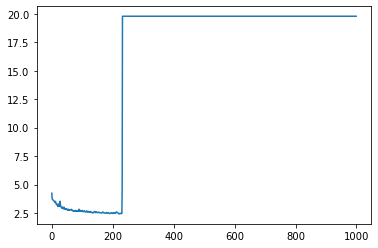

In [23]:
plt.plot(history.history['loss'][:1000])

In [21]:
if history.history['loss'][0] < history.history['loss'][-1]:
    breakme

NameError: name 'breakme' is not defined

### get z for training and test

In [ ]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

In [ ]:
Y_train

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=list(Y_train.flatten()), cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test.flatten(), cmap=plt.cm.tab10)

### Save models + projections

In [ ]:
import os

In [ ]:
output_dir = MODEL_DIR/'projections'/ dataset / 'parametric-tsne'

In [ ]:
encoder.save(os.path.join(output_dir, "encoder"))

In [ ]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [ ]:
from tfumap.silhouette import silhouette_score_block

In [ ]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

In [ ]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

In [ ]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

#### Trustworthiness

In [ ]:
from sklearn.manifold import trustworthiness

In [ ]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [ ]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [ ]:
tw, tw_test

#### save output metrics

In [ ]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

In [ ]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [ ]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

In [ ]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [ ]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

In [ ]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)